In [6]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import  CatBoostClassifier
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import OneSidedSelection, TomekLinks
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from pycaret.classification import *

In [7]:
train = pd.read_csv("./smhrd_data/Train.csv")
train.drop(['ID', 'Gender', 'Discount_offered'], axis=1, inplace=True)
# 결측치의 형태가 ?인 데이터를 NA로 대체
train = train.replace('?', pd.NA)

# Warehouse_block 컬럼 이름에 공백들어가 있어서 재설정
train.columns = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms', 'Reached.on.Time_Y.N']

# 연속형 변수중에서 이상치 제거 (개수가 많지 않을뿐더러 5개를 채우려고 하는 것은 비효율적이라고 생각하기 때문)
train = train[(train['Customer_rating']!=99) & (train['Cost_of_the_Product']!=9999)]

# Mode_of_Shipment에서 끝에 zk가 붙은 이상치 수정
train['Mode_of_Shipment'] = train['Mode_of_Shipment'].apply(lambda x: x.replace('zk', '') if pd.notna(x) else x)
train = train[train['Product_importance'].notnull()]
#train['Product_importance'].fillna('medium', inplace=True)

# Product_importance에서 끝에 m이 하나씩 더붙은 이상치 수정
train['Product_importance'] = train['Product_importance'].apply(lambda x: x[:-1] if x[-1]==x[-2] else x)

train['Weight_in_gms'] = train['Weight_in_gms'].apply(lambda x: int(x) if str(x).isdigit() else x)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6532 non-null   object 
 2   Customer_care_calls  5346 non-null   float64
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      5959 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6453 non-null   object 
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 538.8+ KB


In [173]:
train[train['Weight_in_gms'].notnull()].corr()

C:\Users\dbswo\AppData\Local\Temp\ipykernel_19360\10761830.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train[train['Weight_in_gms'].notnull()].corr()


,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Reached.on.Time_Y.N
Customer_care_calls,1.000000,0.010353,0.342910,0.177983,-0.067939
Customer_rating,0.010353,1.000000,0.002245,0.012258,-0.005384
Cost_of_the_Product,0.342910,0.002245,1.000000,0.138335,-0.064553
Prior_purchases,0.177983,0.012258,0.138335,1.000000,-0.063670
Reached.on.Time_Y.N,-0.067939,-0.005384,-0.064553,-0.063670,1.000000


In [150]:
train['Weight_in_gms'].fillna(0, inplace=True)

In [151]:
df= train[train['Weight_in_gms'].notnull()]
df['Weight_in_gms'] = df['Weight_in_gms'].apply(lambda x : int(x))
df.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Weight_in_gms,Reached.on.Time_Y.N
count,5346.000000,6897.000000,6897.000000,5959.000000,6897.000000,6897.000000
mean,4.054994,2.993330,210.018414,3.576103,3426.853125,0.594606
std,1.131390,1.411016,48.256094,1.531653,1820.326795,0.491004
min,2.000000,1.000000,96.000000,2.000000,0.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,1677.000000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,4070.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,5006.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,7846.000000,1.000000


<Axes: xlabel='Weight_in_gms', ylabel='Count'>

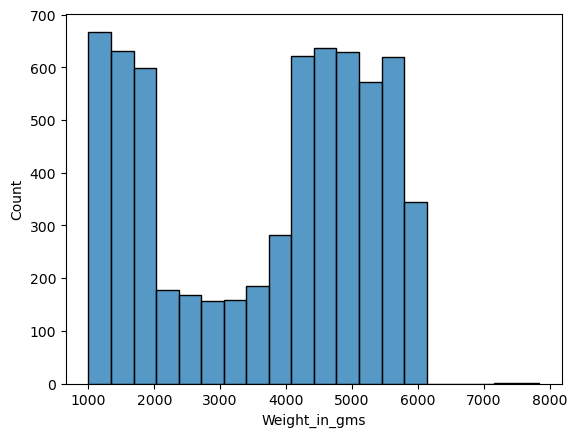

In [108]:
import seaborn as sns
sns.histplot(df['Weight_in_gms'])


In [145]:
train['Product_importance'].value_counts()

low       3344
medium    2980
high       573
Name: Product_importance, dtype: int64

In [146]:
# train['Weight_in_gms'] = train[train['Weight_in_gms'].notnull()]['Weight_in_gms'].astype(int)
# train.corr()

In [8]:
# Mode_of_Shipment의 결측값은 Warehouse_block, Product_importance, Weight_in_gms와 연관이 있지 않을까?
# 하지만 Weight_in_gms는 결측값이 있어서 참고해서 채우기 어려울듯하다.
# 따라서 Warehouse_block, Product_importance를 groupby해서 본 결과 ship이 대부분이라 ship으로 일단 채워보려 한다.
train['Mode_of_Shipment'].fillna(' Ship', inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  5346 non-null   float64
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      5959 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6453 non-null   object 
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 538.8+ KB


In [85]:
train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).median()

Customer_care_calls
Customer_rating Mode_of_Shipment                     
1                Flight                           4.0
                 Road                             4.0
                 Ship                             3.0
2                Flight                           4.0
                 Road                             4.0
                 Ship                             4.0
3                Flight                           4.0
                 Road                             4.0
                 Ship                             4.0
4                Flight                           4.0
                 Road                             4.0
                 Ship                             4.0
5                Flight                           3.0
                 Road                             4.0
                 Ship                             4.0

In [136]:
train[['Customer_care_calls', 'Mode_of_Shipment']].groupby(['Mode_of_Shipment']).mean()

,Customer_care_calls
Mode_of_Shipment,
Flight,4.136536
Road,4.092771
Ship,4.029262


In [137]:
train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])

Customer_care_calls
Customer_rating Mode_of_Shipment                     
1                Flight                           4.0
                 Road                             3.0
                 Ship                             3.0
2                Flight                           5.0
                 Road                             4.0
                 Ship                             4.0
3                Flight                           4.0
                 Road                             4.0
                 Ship                             4.0
4                Flight                           3.0
                 Road                             4.0
                 Ship                             4.0
5                Flight                           3.0
                 Road                             4.0
                 Ship                             4.0

In [138]:
train[['Customer_care_calls', 'Mode_of_Shipment']].groupby(['Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])

,Customer_care_calls
Mode_of_Shipment,
Flight,4.0
Road,4.0
Ship,4.0


In [9]:
# 결측치를 채우기 전 가설
# Customer_care_calls는 배송조회 문의전화 건수로 Customer_rating, Mode_of_Shipment가 관련 있다고 가정
# 생각보다 Customer_care_calls의 범주가 2-7사이로 다양하지 않음. 평균일 경우 모두 4 최빈값일 경우는 3,4,5가 나타난다.
# 따라서 하나라도 다른 최빈값이 데이터의 특성을 더 반영하고 있다고 추측하여 최빈값으로 채우기로 함
def fill_calls(row) :
    if np.isnan(row['Customer_care_calls']):
        return pt1.loc[(row['Customer_rating'], row['Mode_of_Shipment'])]
    else:
        return row['Customer_care_calls']

pt1 = train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])
train['Customer_care_calls'] = train.apply(fill_calls, axis = 1).astype('int64')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      5959 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6453 non-null   object 
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 538.8+ KB


In [127]:
# 결측치를 채우기 전 가설
# Customer_care_calls는 배송조회 문의전화 건수로 Customer_rating, Mode_of_Shipment가 관련 있다고 가정
# 생각보다 Customer_care_calls의 범주가 2-7사이로 다양하지 않음. 평균일 경우 모두 4 최빈값일 경우는 3,4,5가 나타난다.
# 따라서 하나라도 다른 최빈값이 데이터의 특성을 더 반영하고 있다고 추측하여 최빈값으로 채우기로 함
def fill_calls(row) :
    if np.isnan(row['Customer_care_calls']):
        return pt1.loc[(row['Customer_rating'], row['Mode_of_Shipment'])]
    else:
        return row['Customer_care_calls']

pt1 = train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).mean()
train['Customer_care_calls'] = train.apply(fill_calls, axis = 1).astype('int64')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      5959 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6453 non-null   object 
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 538.8+ KB


(array([1325.,  790.,  330.,  353.,  915., 1274., 1209.,  349.,    0.,
           3.]),
 array([1001. , 1685.5, 2370. , 3054.5, 3739. , 4423.5, 5108. , 5792.5,
        6477. , 7161.5, 7846. ]),
 <BarContainer object of 10 artists>)

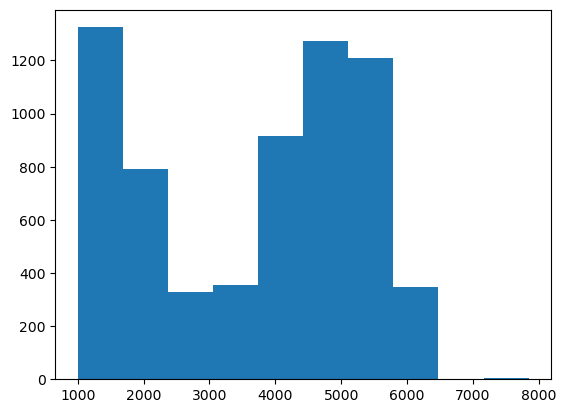

In [109]:
import matplotlib.pyplot as plt
plt.hist(train[train['Weight_in_gms'].notnull()]['Weight_in_gms'])

In [187]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      5959 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6453 non-null   object 
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 538.8+ KB


In [135]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
def stochastic_regression_imputation(df, target_column, feature_column):
    # 결측값과 비결측값을 분리하여 학습 데이터와 예측 데이터 생성
    train_data = df.dropna(subset=[target_column])
    test_data = df[df[target_column].isnull()]

    # 선형 회귀 모델 학습
    
    model.fit(train_data[[feature_column]], train_data[target_column])

    # 예측값 생성
    predictions = model.predict(test_data[[feature_column]])

    # 예측값으로 결측값 대체
    df.loc[df[target_column].isnull(), target_column] = predictions

# Stochastic regression imputation 실행
stochastic_regression_imputation(train, 'Weight_in_gms', 'Customer_care_calls')
train['Weight_in_gms'] = train['Weight_in_gms'].apply(lambda x:int(x))

# 결측값이 대체된 데이터 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      5959 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6897 non-null   int64  
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 538.8+ KB


In [10]:
train['Weight_in_gms'].fillna(3424, inplace=True)
train['Weight_in_gms'] = train['Weight_in_gms'].apply(lambda x:int(x))
train.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Weight_in_gms,Reached.on.Time_Y.N
count,6897.000000,6897.000000,6897.000000,5959.000000,6897.000000,6897.000000
mean,3.994490,2.993330,210.018414,3.576103,3647.275917,0.594606
std,1.026744,1.411016,48.256094,1.531653,1583.951177,0.491004
min,2.000000,1.000000,96.000000,2.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,1915.000000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,4070.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,5006.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,7846.000000,1.000000


In [193]:
train['Weight_in_gms'] = train['Weight_in_gms'].apply(lambda x:int(x))
train.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Weight_in_gms,Reached.on.Time_Y.N
count,6897.000000,6897.000000,6897.000000,5959.000000,6897.00000,6897.000000
mean,3.994490,2.993330,210.018414,3.576103,3663.30187,0.594606
std,1.026744,1.411016,48.256094,1.531653,1586.00425,0.491004
min,2.000000,1.000000,96.000000,2.000000,1001.00000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,1915.00000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,4078.00000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,5006.00000,1.000000
max,7.000000,5.000000,310.000000,10.000000,7846.00000,1.000000


In [140]:
## gms 경우는 평균이 히스토그램에 따르면 데이터의 성질을 잘 반영하지 못한다고 생각하여 median으로 시도했으나
# accuracy기준으로 mean의 성능이 더높게 나오는듯하여 mean으로 교체
def fill_gms(row) :
    if pd.isnull(row['Weight_in_gms']):
        return pt2.loc[(row['Mode_of_Shipment'])]
    else:
        return row['Weight_in_gms']
pt2 = train[['Mode_of_Shipment', 'Weight_in_gms']].groupby(['Mode_of_Shipment']).median()
train['Weight_in_gms'] = train.apply(fill_gms, axis = 1).astype('int64')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      5959 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6897 non-null   int64  
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 538.8+ KB


In [150]:
# Product_importance별 평균값으로 대체
def fill_gms(row) :
    if pd.isnull(row['Weight_in_gms']):
        return pt2.loc[(row['Product_importance'])]
    else:
        return row['Weight_in_gms']
pt2 = train[['Product_importance', 'Weight_in_gms']].groupby(['Product_importance']).median()
train['Weight_in_gms'] = train.apply(fill_gms, axis = 1).astype('int64')
train.info()
pt2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      5959 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6897 non-null   int64  
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 538.8+ KB


,Weight_in_gms
Product_importance,
high,4451.0
low,4078.0
medium,4243.5


In [11]:
train['Prior_purchases'].value_counts()
train['Prior_purchases'] = train['Prior_purchases'].apply(lambda x: 3 if pd.isnull(x) else x)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      6897 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6897 non-null   int64  
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 538.8+ KB


### Customer_rating에는 이상치 99가 있다 -> Customer_care_calls 몇 이상? 인 사람들의 평균 Customer_rating로 바꾸면 되지 않을까?
### 결측치도 있지만 ?인 컬럼도 존재한다
###  Discount_offered 는 결측치가 너무 많아서 사용할 수 없을듯하다.
### Gender는 중요도가 그다지 높아보이지 않는다.
### customer_care_calls 는 도착여부와 관련이 있는듯함.  -> 전화를 많이해서 도착을 한것일까, 도착을 많이 안해서 전화를 많이 한것인가?
### prior_purchases는 겉으로는 중요해보이지 않지만 회사 내부에서 vip 고객일수록 배송을 우선시한다는 가정을 해본다면 prior_purchases구간화를 진행하고 도착여부에 따른 groupby를 진행해서 채울 수 있지 않을까?
### Mode_of_shipment는 Weight_in_gms와 warehouse_block 

## 전처리 관련
- 1. 결측치 null 대신 ?로 표시되어 있는 데이터들을 nan으로 변경
- 2. Discount_offered는 결측치가 너무 많아 사용하기 힘들듯하다
- 3. Mode_of_Shipment, Product_importance에 가벼운 오타를 수정필요
- 4. 결측치 채우는 순서는 결측치가 적은 컬럼부터 채우는것이 맞지 않을까? (결측치 컬럼을 채울 때 결측치가 있는 컬럼을 참고할 수는 없기 때문?, 만약 결측치가 없는 컬럼을 보고 채운다면 얘기가 다름)
- 5. 위의 4번대로라면 결측치 채울 순서는 Product_importance, Mode_of_Shipment, Weight_in_gms, Prior_purchases, Customer_care_calls
- 6. 범주형 변수와 연속형 변수가 섞여있기 때문에 변수 타입이 섞여있을 때의 상관관계를 볼 수 있을지 알아봐야할듯 (Point biserial correlation라는 것이 있다하는데 scipy.stats라이브러리 알아봐야할듯)

- customer_care_calls 는 도착여부와 관련이 있는듯함.  -> 전화를 많이해서 도착을 한것일까, 도착을 많이 안해서 전화를 많이 한것인가?
- prior_purchases는 겉으로는 중요해보이지 않지만 회사 내부에서 vip 고객일수록 배송을 우선시한다는 가정을 해본다면 prior_purchases구간화를 진행하고 도착여부에 따른 groupby를 진행해서 채울 수 있지 않을까?

In [338]:
train['Reached.on.Time_Y.N'].value_counts()

1    4101
0    2796
Name: Reached.on.Time_Y.N, dtype: int64

In [11]:
#!pip install catboost
#!pip install xgboost
#!pip install lightgbm

     ---------------------------------------- 1.3/1.3 MB 27.6 MB/s eta 0:00:00


## 모델 훈련

In [344]:
train.columns

Index(['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms', 'Reached.on.Time_Y.N'],
      dtype='object')

In [145]:
from sklearn.preprocessing import LabelEncoder
object_columns = train.select_dtypes('object').columns

for i in object_columns:

    lb = LabelEncoder()
    lb.fit(train[i])
    train[i] = lb.transform(train[i])
    
    print(f'category : {np.unique(train[i])}\nclasses : {lb.classes_}\n')

category : [0 1 2 3 4]
classes : ['A' 'B' 'C' 'D' 'F']

category : [0 1 2]
classes : [' Flight' ' Road' ' Ship']

category : [0 1 2]
classes : ['high' 'low' 'medium']



In [19]:
input = train.iloc[:,:-1]
target = train.iloc[:,-1]

## Ada

In [23]:
object_columns = train.select_dtypes('object').columns
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)
ab = AdaBoostClassifier(algorithm='SAMME', learning_rate=0.97, n_estimators=2, random_state=42)
ab.fit(x_train_ss, y_train)
pred = ab.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6603864734299517
0.6811791383219955


array([[616, 216],
       [487, 751]], dtype=int64)

In [38]:
result = cross_val_score(ab, x_train, y_train)
print(result)
print(result.mean())

[0.68219462 0.64596273 0.67150259 0.64663212 0.66839378]
0.6629371694611614


In [307]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)
object_columns = train.select_dtypes('object').columns

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

ab = AdaBoostClassifier(random_state=42)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

param_grid = {
    'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20],
    'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
    'algorithm': ['SAMME', 'SAMME.R']
}
from sklearn.model_selection import GridSearchCV
ab_grid = GridSearchCV(ab, param_grid, scoring='accuracy')
ab_grid.fit(x_train_ss, y_train)
print(f'best accuracy : {ab_grid.best_score_}')
print('best param : ', ab_grid.best_params_)
pred = ab_grid.predict(x_test_ss)
confusion_matrix(y_test, pred)

best accuracy : 0.667700790611356
best param :  {'algorithm': 'SAMME', 'learning_rate': 0.97, 'n_estimators': 2}


array([[616, 216],
       [487, 751]], dtype=int64)

## gbm

In [183]:
object_columns = train.select_dtypes('object').columns
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)
gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7, random_state=42)
gb.fit(x_train_ss, y_train)
pred = gb.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6705314009661836
0.678301886792453


array([[669, 163],
       [519, 719]], dtype=int64)

In [159]:
result = cross_val_score(gb, x_train, y_train)
print(result)
print(result.mean())

[0.68530021 0.66873706 0.67150259 0.66321244 0.65699482]
0.6691494223280662


In [36]:
result = cross_val_score(gb, x_train, y_train)
print(result)
print(result.mean())

[0.67701863 0.67287785 0.65699482 0.66217617 0.6507772 ]
0.6639689333719521


In [11]:
object_columns = train.select_dtypes('object').columns
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)
gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500,
                           random_state=42)
gb.fit(x_train_ss, y_train)
pred = gb.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6608695652173913
0.6660323501427212


array([[668, 164],
       [538, 700]], dtype=int64)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)
object_columns = train.select_dtypes('object').columns

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

gb = GradientBoostingClassifier(random_state=42)

param_grid = {'n_estimators': [50, 100, 500],
             'learning_rate': [0.001, 0.01, 0.1, 1.0],
              'subsample':[0.5, 0.7, 1.0],
              'max_depth':[4, 7, 10]
             }
from sklearn.model_selection import GridSearchCV
gb_grid = GridSearchCV(gb, param_grid, scoring='accuracy')
gb_grid.fit(x_train_ss, y_train)
print(f'best accuracy : {gb_grid.best_score_}')
print('best param : ', gb_grid.best_params_)
pred = gb_grid.predict(x_test_ss)
confusion_matrix(y_test, pred)

best accuracy : 0.6727272727272728
best param :  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'subsample': 1.0}


array([[675, 169],
       [536, 719]], dtype=int64)

## lgbm

In [27]:
#!pip install optuna
import optuna
from optuna import Trial as trial

In [12]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)
lgbm = LGBMClassifier(random_state=42, colsample_bytree = 0.8, 
                      learning_rate = 0.1, max_depth = 4, 
                      min_child_samples = 10, n_estimators = 50, 
                      subsample = 0.7)
lgbm.fit(x_train_ss, y_train)
pred = lgbm.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

[LightGBM] [Info] Number of positive: 2863, number of negative: 1964
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 4827, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593122 -> initscore=0.376887
[LightGBM] [Info] Start training from score 0.376887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[641, 191],
       [539, 699]], dtype=int64)

In [40]:
result = cross_val_score(lgbm, x_train, y_train)
print(result)
print(result.mean())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2290, number of negative: 1571
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 499
[LightGBM] [Info] Number of data points in the train set: 3861, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593111 -> initscore=0.376839
[LightGBM] [Info] Start training from score 0.376839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [67]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)
object_columns = train.select_dtypes('object').columns

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

lgbm = LGBMClassifier(random_state=42)
param_grid = {   
        'learning_rate': [0.1, 0.01],
        'n_estimators': [50, 100, 150],
        'max_depth': [4, 6],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'subsample': [0.7, 0.8, 0.9],
        'min_child_samples': [1, 5, 10]
        }

    
from sklearn.model_selection import GridSearchCV
lgbm_grid = GridSearchCV(lgbm, param_grid, scoring='accuracy')
lgbm_grid.fit(x_train_ss, y_train)
print(f'best accuracy : {lgbm_grid.best_score_}')
print('best param : ', lgbm_grid.best_params_)
pred = gb_grid.predict(x_test_ss)
confusion_matrix(y_test, pred)

[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593207 -> initscore=0.377240
[LightGBM] [Info] Start training from score 0.377240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593207 -> initscore=0.377240
[LightGBM] [Info] Start training from score 0.377240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593207 -> initscore=0.377240
[LightGBM] [Info] Start training from score 0.377240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593207 -> initscore=0.377240
[LightGBM] [Info] Start training from score 0.377240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593207 -> initscore=0.377240
[LightGBM] [Info] Start training from score 0.377240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593207 -> initscore=0.377240
[LightGBM] [Info] Start training from score 0.377240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593207 -> initscore=0.377240
[LightGBM] [Info] Start training from score 0.377240
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_l

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warn

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593207 -> initscore=0.377240
[LightGBM] [Info] Start training from score 0.377240
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593207 -> initscore=0.377240
[LightGBM] [Info] Start training 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth >

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Star

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromSc

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad sinc

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warnin

[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] 

[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] 

[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the 

[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593207 -> initscore=0.377240
[LightGBM] [Info] Start training from score 0.377240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593207 -> initscore=0.377240
[LightGBM] [Info] Start training from score 0.377240
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_l

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_l

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] Accuracy may be bad since you didn

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] Accuracy may be bad since you didn

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593207 -> initscore=0.377240
[LightGBM] [Info] Start training from score 0.377240
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_l

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] Accuracy may be bad since you didn

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] Accuracy may be bad since you didn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] Accuracy may be bad sin

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2322, number of negative: 1594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592952 -> initscore=0.376182
[LightGBM] [Info] Start training from score 0.376182
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_l

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2323, number of negative: 1593
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593207 -> initscore=0.377240
[LightGBM] [Info] Start training from score 0.377240
[LightGBM] [Warning] Accuracy may be bad since you didn

KeyboardInterrupt: 

In [34]:
print(f'best accuracy : {lgbm_grid.best_score_}')
print('best param : ', lgbm_grid.best_params_)

best accuracy : 0.6701837608212918
best param :  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_samples': 10, 'n_estimators': 50, 'subsample': 0.7}


In [31]:
pred = lgbm_grid.predict(x_test_ss)
confusion_matrix(y_test, pred)

array([[666, 166],
       [551, 687]], dtype=int64)

## SVC

In [ ]:
from sklearn.preprocessing import LabelEncoder
object_columns = train.select_dtypes('object').columns

for i in object_columns:

    lb = LabelEncoder()
    lb.fit(train[i])
    train[i] = lb.transform(train[i])
    
    print(f'category : {np.unique(train[i])}\nclasses : {lb.classes_}\n')

In [200]:
input = train.iloc[:,:-1]
target = train.iloc[:,-1]

input

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Weight_in_gms
0,2,2,2,2,135,3.0,1,1339
1,4,0,5,3,225,5.0,1,1082
2,4,2,3,1,229,3.0,1,4971
3,4,2,3,2,228,3.0,2,5640
4,3,0,4,1,195,6.0,0,4944
...,...,...,...,...,...,...,...,...
6994,3,2,4,2,232,5.0,2,1783
6995,4,2,3,5,228,2.0,2,5208
6996,3,2,3,1,300,5.0,1,1787
6997,0,1,3,1,232,2.0,2,4719


In [232]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

svc = SVC(random_state=42)
svc.fit(x_train_ss, y_train)
pred = svc.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6415458937198067
0.7180851063829787


array([[383, 449],
       [293, 945]], dtype=int64)

In [228]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

svc = SVC(C=0.1, gamma=10, random_state=42)
svc.fit(x_train_ss, y_train)
pred = svc.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.5971014492753624
0.7435424354243543


In [229]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[  27,  805],
       [  29, 1209]], dtype=int64)

In [351]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

svc = SVC(C=100, gamma=0.01, random_state=42)
svc.fit(x_train_ss, y_train)
pred = svc.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.6352657004830918
0.7024044146629878


In [231]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[441, 391],
       [357, 881]], dtype=int64)

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'gamma': [0.001, 0.01, 0.1, 1, 10, 100] }
from sklearn.model_selection import GridSearchCV
svc_grid = GridSearchCV(SVC, param_grid, scoring='accuracy')
svc_grid.fit(x_train_ss, y_train)
print(f'best f1 : {svc_grid.best_score_}')
print('best param : ', svc_grid.best_params_)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

svc = SVC(random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'gamma': [0.001, 0.01, 0.1, 1, 10, 100] }
from sklearn.model_selection import GridSearchCV
svc_grid = GridSearchCV(svc, param_grid, scoring='accuracy')
svc_grid.fit(x_train_ss, y_train)
print(f'best f1 : {svc_grid.best_score_}')
print('best param : ', svc_grid.best_params_)
pred = svc_grid.predict(x_test_ss)
confusion_matrix(y_test, pred)

best f1 : 0.6416751787538304
best param :  {'C': 100, 'gamma': 0.01}


array([[444, 400],
       [348, 907]], dtype=int64)

## mlp

In [14]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

mp = MLPClassifier(activation='tanh', solver='adam', alpha=1, max_iter=1000)
mp.fit(x_train_ss, y_train)
# param_grid={'hidden_layer_sizes': [10, 30, 50, 100], 'solver': ['sgd', 'adam'], 
#              'activation': ['tanh', 'relu']}
# from sklearn.model_selection import GridSearchCV
# mp_grid = grid_search=GridSearchCV(mp, param_grid, scoring='f1')
# mp_grid.fit(x_train_ss, y_train)
# print(f'best f1 : {mp_grid.best_score_}')
# print('best param : ', mp_grid.best_params_)
pred = mp.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6222222222222222
0.7122884473877852


array([[320, 512],
       [270, 968]], dtype=int64)

In [35]:
result = cross_val_score(mp, x_train, y_train)
print(result)
print(result.mean())

[0.65113872 0.64285714 0.62072539 0.64248705 0.63626943]
0.638695544899645


In [20]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

mp = MLPClassifier(activation='tanh', hidden_layer_sizes=100, solver='adam', alpha=1, max_iter=1000)
param_grid={'hidden_layer_sizes': [50, 100], 'solver': ['adam'], 
             'activation': ['tanh', 'relu'], 'alpha': ([0.01,0.001, 0.0001]),   'learning_rate_init': [0.01, 0.001]}
from sklearn.model_selection import GridSearchCV
mp_grid = GridSearchCV(mp, param_grid, scoring='accuracy')
mp_grid.fit(x_train_ss, y_train)
print(f'best accuracy : {mp_grid.best_score_}')
print('best param : ', mp_grid.best_params_)
pred = mp_grid.predict(x_test_ss)
confusion_matrix(y_test, pred)

best accuracy : 0.6494382022471911
best param :  {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01, 'solver': 'adam'}


array([[453, 391],
       [373, 882]], dtype=int64)

In [199]:
## mean
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)
object_columns = train.select_dtypes('object').columns

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

mp = MLPClassifier(activation='tanh', hidden_layer_sizes=100, solver='adam', 
                   alpha=0.0001, max_iter=1000, learning_rate_init=0.01, random_state=42)
mp.fit(x_train_ss, y_train)
pred = mp.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6502415458937199
0.679646017699115


array([[578, 254],
       [470, 768]], dtype=int64)

In [286]:
## median
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)
object_columns = train.select_dtypes('object').columns

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

mp = MLPClassifier(activation='tanh', hidden_layer_sizes=100, solver='adam', 
                   alpha=0.0001, max_iter=1000, learning_rate_init=0.01, random_state=42)
mp.fit(x_train_ss, y_train)
pred = mp.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6483091787439613
0.6767317939609236


array([[580, 252],
       [476, 762]], dtype=int64)

### DecisionTree

In [20]:
## median
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)
object_columns = train.select_dtypes('object').columns

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)


tree = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=11, min_samples_leaf=21,
                       min_samples_split=51)

tree.fit(x_train, y_train)
pred = tree.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.5980676328502416
0.7484885126964934


C:\Users\user21\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([[   0,  832],
       [   0, 1238]], dtype=int64)

### Voting

In [114]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)
object_columns = train.select_dtypes('object').columns

for column in object_columns:
    dummy = pd.get_dummies(x_train[column], prefix=column)
    x_train = pd.concat([x_train, dummy], axis = 1)
    x_train.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(x_test[column], prefix=column)
    x_test = pd.concat([x_test, dummy], axis = 1)
    x_test.drop(column, axis = 1, inplace=True)

ss = MinMaxScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

svc = SVC(C=100, gamma=0.01, random_state=42, probability=True)
lgbm = LGBMClassifier(random_state=42, colsample_bytree = 0.8, 
                      learning_rate = 0.1, max_depth = 4, 
                      min_child_samples = 10, n_estimators = 50, 
                      subsample = 0.7)
mp = MLPClassifier(activation='tanh', hidden_layer_sizes=100, solver='adam', alpha=0.0001, max_iter=1000, learning_rate_init=0.01)
gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7, random_state=42)

voting_model = VotingClassifier(estimators=
                               [('svc',svc),
                               ('mp', mp),
                               ('gb', gb)],
                               voting='soft'
                               )
voting_model.fit(x_train_ss, y_train)

VotingClassifier(estimators=[('svc',
                              SVC(C=100, gamma=0.01, probability=True,
                                  random_state=42)),
                             ('mp',
                              MLPClassifier(activation='tanh',
                                            hidden_layer_sizes=100,
                                            learning_rate_init=0.01,
                                            max_iter=1000)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         max_depth=4,
                                                         n_estimators=500,
                                                         random_state=42,
                                                         subsample=0.7))],
                 voting='soft')

In [115]:
pred = voting_model.predict(x_test_ss)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

0.6318840579710145
0.7011764705882353


array([[414, 418],
       [344, 894]], dtype=int64)

## python 3.10.9 사용중

### 일단 svm 모델이 가장 높아보이니 시도

In [68]:
train = pd.read_csv("./smhrd_data/Train.csv")
train.drop(['ID', 'Gender', 'Discount_offered'], axis=1, inplace=True)
# 결측치의 형태가 ?인 데이터를 NA로 대체
train = train.replace('?', pd.NA)

# Warehouse_block 컬럼 이름에 공백들어가 있어서 재설정
train.columns = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms', 'Reached.on.Time_Y.N']

# 연속형 변수중에서 이상치 제거 (개수가 많지 않을뿐더러 5개를 채우려고 하는 것은 비효율적이라고 생각하기 때문)
train = train[(train['Customer_rating']!=99) & (train['Cost_of_the_Product']!=9999)]

# Mode_of_Shipment에서 끝에 zk가 붙은 이상치 수정
train['Mode_of_Shipment'] = train['Mode_of_Shipment'].apply(lambda x: x.replace('zk', '') if pd.notna(x) else x)
train = train[train['Product_importance'].notnull()]

# Product_importance에서 끝에 m이 하나씩 더붙은 이상치 수정
train['Product_importance'] = train['Product_importance'].apply(lambda x: x[:-1] if x[-1]==x[-2] else x)

train['Weight_in_gms'] = train['Weight_in_gms'].apply(lambda x: int(x) if str(x).isdigit() else x)
train['Mode_of_Shipment'].fillna(' Ship', inplace=True)

def fill_calls(row) :
    if np.isnan(row['Customer_care_calls']):
        return pt1.loc[(row['Customer_rating'], row['Mode_of_Shipment'])]
    else:
        return row['Customer_care_calls']

pt1 = train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])
train['Customer_care_calls'] = train.apply(fill_calls, axis = 1).astype('int64')

def fill_gms(row) :
    if pd.isnull(row['Weight_in_gms']):
        return pt2.loc[(row['Mode_of_Shipment'])]
    else:
        return row['Weight_in_gms']
    
pt2 = train[['Mode_of_Shipment', 'Weight_in_gms']].groupby(['Mode_of_Shipment']).median()
train['Weight_in_gms'] = train.apply(fill_gms, axis = 1).astype('int64')

train['Prior_purchases'] = train['Prior_purchases'].apply(lambda x: 3 if pd.isnull(x) else x)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      6897 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6897 non-null   int64  
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 538.8+ KB


In [69]:
test = pd.read_csv("./smhrd_data/test.csv")

test.drop(['ID', 'Gender', 'Discount_offered'], axis=1, inplace=True)
# 결측치의 형태가 ?인 데이터를 NA로 대체
test = test.replace('?', pd.NA)

# Warehouse_block 컬럼 이름에 공백들어가 있어서 재설정
test.columns = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms']

# 연속형 변수중에서 이상치 제거 (개수가 많지 않을뿐더러 5개를 채우려고 하는 것은 비효율적이라고 생각하기 때문)
# test = test[(test['Customer_rating']!=99) & (test['Cost_of_the_Product']!=9999)]

# Mode_of_Shipment에서 끝에 zk가 붙은 이상치 수정
test['Mode_of_Shipment'] = test['Mode_of_Shipment'].apply(lambda x: x.replace('zk', '') if pd.notna(x) else x)
test['Product_importance'].fillna('low', inplace=True)

# Product_importance에서 끝에 m이 하나씩 더붙은 이상치 수정
test['Product_importance'] = test['Product_importance'].apply(lambda x: x[:-1] if x[-1]==x[-2] else x)

test['Weight_in_gms'] = test['Weight_in_gms'].apply(lambda x: int(x) if str(x).isdigit() else x)
test['Mode_of_Shipment'].fillna(' Ship', inplace=True)

def fill_calls(row) :
    if np.isnan(row['Customer_care_calls']):
        return pt1.loc[(row['Customer_rating'], row['Mode_of_Shipment'])]
    else:
        return row['Customer_care_calls']

pt1 = train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])
test['Customer_care_calls'] = test.apply(fill_calls, axis = 1).astype('int64')

def fill_gms(row) :
    if pd.isnull(row['Weight_in_gms']):
        return pt2.loc[(row['Mode_of_Shipment'])]
    else:
        return row['Weight_in_gms']
pt2 = train[['Mode_of_Shipment', 'Weight_in_gms']].groupby(['Mode_of_Shipment']).median()
test['Weight_in_gms'] = test.apply(fill_gms, axis = 1).astype('int64')

test['Prior_purchases'] = test['Prior_purchases'].apply(lambda x: 3 if pd.isnull(x) else x)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      4000 non-null   object 
 1   Mode_of_Shipment     4000 non-null   object 
 2   Customer_care_calls  4000 non-null   int64  
 3   Customer_rating      4000 non-null   int64  
 4   Cost_of_the_Product  4000 non-null   int64  
 5   Prior_purchases      4000 non-null   float64
 6   Product_importance   4000 non-null   object 
 7   Weight_in_gms        4000 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 250.1+ KB


In [70]:
# object_columns = train.select_dtypes('object').columns

# for i in object_columns:

#     lb = LabelEncoder()
#     lb.fit(train[i])
#     train[i] = lb.transform(train[i])
#     test[i] = lb.transform(test[i])
    
#     print(f'train category : {np.unique(train[i])}\nclasses : {lb.classes_}\n')
#     print(f'test category : {np.unique(test[i])}\nclasses : {lb.classes_}\n')

input = train.iloc[:,:-1]
target = train.iloc[:,-1]

In [49]:
ss = StandardScaler()
input_ss = ss.fit_transform(input)
test_ss = ss.transform(test)

svc = SVC(random_state=42)
svc.fit(input_ss, target)
pred_svc = svc.predict(test_ss)

ValueError: could not convert string to float: 'C'

In [433]:
result = pd.read_csv('./smhrd_data/sampleSubmission.csv')
result['Reached.on.Time_Y.N'] = pred_svc
result.to_csv('result.csv', index=False)

## mlp 시도 추가

In [255]:
object_columns = train.select_dtypes('object').columns
for column in object_columns:
    dummy = pd.get_dummies(input[column], prefix=column)
    input = pd.concat([input, dummy], axis = 1)
    input.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(test[column], prefix=column)
    test = pd.concat([test, dummy], axis = 1)
    test.drop(column, axis = 1, inplace=True)

In [256]:
ss = StandardScaler()
input_ss = ss.fit_transform(input)
test_ss = ss.transform(test)

mp = MLPClassifier(activation='tanh', hidden_layer_sizes=100, solver='adam', alpha=0.0001, max_iter=1000, learning_rate_init=0.01)
mp.fit(input_ss, target)
pred = mp.predict(test_ss)

In [257]:
result = pd.read_csv('result_mlp_01.csv')
result['Reached.on.Time_Y.N'] = pred
count = 0
for i in range(len(pred)):
    if result['Reached.on.Time_Y.N'][i]==pred[i]:
        count += 1
        
print(count)

4000


In [37]:
result['Reached.on.Time_Y.N']

0       1
1       1
2       0
3       1
4       0
       ..
3995    1
3996    1
3997    1
3998    1
3999    1
Name: Reached.on.Time_Y.N, Length: 4000, dtype: int64

## gbm

In [71]:
object_columns = train.select_dtypes('object').columns
for column in object_columns:
    dummy = pd.get_dummies(input[column], prefix=column)
    input = pd.concat([input, dummy], axis = 1)
    input.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(test[column], prefix=column)
    test = pd.concat([test, dummy], axis = 1)
    test.drop(column, axis = 1, inplace=True)
    
ss = MinMaxScaler()
input_ss = ss.fit_transform(input)
test_ss = ss.transform(test)

gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7, random_state=42)
gb.fit(input_ss, target)
pred = gb.predict(test_ss)

In [45]:
result = pd.read_csv('./smhrd_data/sampleSubmission.csv')
result['Reached.on.Time_Y.N'] = pred
result.to_csv('result_gbm01.csv', index=False)

In [72]:
result = pd.read_csv('result_gbm01.csv')
count = 0
for i in range(len(pred)):
    if result['Reached.on.Time_Y.N'][i]==pred[i]:
        count += 1
        
print(count)

4000


## lgbm

In [86]:
object_columns = train.select_dtypes('object').columns
for column in object_columns:
    dummy = pd.get_dummies(input[column], prefix=column)
    input = pd.concat([input, dummy], axis = 1)
    input.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(test[column], prefix=column)
    test = pd.concat([test, dummy], axis = 1)
    test.drop(column, axis = 1, inplace=True)
    
ss = MinMaxScaler()
input_ss = ss.fit_transform(input)
test_ss = ss.transform(test)

lgbm = LGBMClassifier(random_state=42, colsample_bytree = 0.8, 
                      learning_rate = 0.1, max_depth = 4, 
                      min_child_samples = 10, n_estimators = 50, 
                      subsample = 0.7)
lgbm.fit(input_ss, target)
pred = lgbm.predict(test_ss)

[LightGBM] [Info] Number of positive: 4101, number of negative: 2796
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 6897, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.594606 -> initscore=0.383041
[LightGBM] [Info] Start training from score 0.383041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [87]:
lgbm.feature_importances_

array([ 46,  42, 194,  57, 245,  15,   5,   4,   5,   9,  10,   7,  20,
        15,   6,   8])

In [57]:
result = pd.read_csv('./smhrd_data/sampleSubmission.csv')
result['Reached.on.Time_Y.N'] = pred
result.to_csv('result_lgbm01.csv', index=False)

In [55]:
result = pd.read_csv('result_gbm01.csv')
count = 0
for i in range(len(pred)):
    if result['Reached.on.Time_Y.N'][i]==pred[i]:
        count += 1
        
print(count)

3708


In [56]:
result

,ID,Reached.on.Time_Y.N
0,7000,0
1,7001,1
2,7002,0
3,7003,1
4,7004,0
...,...,...
3995,10995,1
3996,10996,1
3997,10997,0
3998,10998,1


## ---------------------------------------------

## stochastic regression imputation

In [2]:
train = pd.read_csv("./smhrd_data/Train.csv")
train.drop(['ID', 'Gender', 'Discount_offered'], axis=1, inplace=True)
# 결측치의 형태가 ?인 데이터를 NA로 대체
train = train.replace('?', pd.NA)

# Warehouse_block 컬럼 이름에 공백들어가 있어서 재설정
train.columns = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms', 'Reached.on.Time_Y.N']

# 연속형 변수중에서 이상치 제거 (개수가 많지 않을뿐더러 5개를 채우려고 하는 것은 비효율적이라고 생각하기 때문)
train = train[(train['Customer_rating']!=99) & (train['Cost_of_the_Product']!=9999)]

# Mode_of_Shipment에서 끝에 zk가 붙은 이상치 수정
train['Mode_of_Shipment'] = train['Mode_of_Shipment'].apply(lambda x: x.replace('zk', '') if pd.notna(x) else x)
train = train[train['Product_importance'].notnull()]

# Product_importance에서 끝에 m이 하나씩 더붙은 이상치 수정
train['Product_importance'] = train['Product_importance'].apply(lambda x: x[:-1] if x[-1]==x[-2] else x)

train['Weight_in_gms'] = train['Weight_in_gms'].apply(lambda x: int(x) if str(x).isdigit() else x)
train['Mode_of_Shipment'].fillna(' Ship', inplace=True)

def fill_calls(row) :
    if np.isnan(row['Customer_care_calls']):
        return pt1.loc[(row['Customer_rating'], row['Mode_of_Shipment'])]
    else:
        return row['Customer_care_calls']

pt1 = train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])
train['Customer_care_calls'] = train.apply(fill_calls, axis = 1).astype('int64')
from sklearn.linear_model import LinearRegression
model = LinearRegression()


def stochastic_regression_imputation(df, target_column, feature_column):
    # 결측값과 비결측값을 분리하여 학습 데이터와 예측 데이터 생성
    train_data = df.dropna(subset=[target_column])
    test_data = df[df[target_column].isnull()]

    # 선형 회귀 모델 학습
    
    model.fit(train_data[[feature_column]], train_data[target_column])

    # 예측값 생성
    predictions = model.predict(test_data[[feature_column]])

    # 예측값으로 결측값 대체
    df.loc[df[target_column].isnull(), target_column] = predictions

# Stochastic regression imputation 실행
stochastic_regression_imputation(train, 'Weight_in_gms', 'Customer_care_calls')
train['Weight_in_gms'] = train['Weight_in_gms'].apply(lambda x:int(x))

train['Prior_purchases'] = train['Prior_purchases'].apply(lambda x: 3 if pd.isnull(x) else x)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      6897 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6897 non-null   int64  
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 538.8+ KB


In [3]:
test = pd.read_csv("./smhrd_data/test.csv")

test.drop(['ID', 'Gender', 'Discount_offered'], axis=1, inplace=True)
# 결측치의 형태가 ?인 데이터를 NA로 대체
test = test.replace('?', pd.NA)

# Warehouse_block 컬럼 이름에 공백들어가 있어서 재설정
test.columns = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms']

# 연속형 변수중에서 이상치 제거 (개수가 많지 않을뿐더러 5개를 채우려고 하는 것은 비효율적이라고 생각하기 때문)
# test = test[(test['Customer_rating']!=99) & (test['Cost_of_the_Product']!=9999)]

# Mode_of_Shipment에서 끝에 zk가 붙은 이상치 수정
test['Mode_of_Shipment'] = test['Mode_of_Shipment'].apply(lambda x: x.replace('zk', '') if pd.notna(x) else x)
test['Product_importance'].fillna('low', inplace=True)

# Product_importance에서 끝에 m이 하나씩 더붙은 이상치 수정
test['Product_importance'] = test['Product_importance'].apply(lambda x: x[:-1] if x[-1]==x[-2] else x)

test['Weight_in_gms'] = test['Weight_in_gms'].apply(lambda x: int(x) if str(x).isdigit() else x)
test['Mode_of_Shipment'].fillna(' Ship', inplace=True)

def fill_calls(row) :
    if np.isnan(row['Customer_care_calls']):
        return pt1.loc[(row['Customer_rating'], row['Mode_of_Shipment'])]
    else:
        return row['Customer_care_calls']

pt1 = train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])
test['Customer_care_calls'] = test.apply(fill_calls, axis = 1).astype('int64')

def stochastic_regression_imputation(df, target_column, feature_column):
    # 결측값과 비결측값을 분리하여 학습 데이터와 예측 데이터 생성
    test_data = df[df[target_column].isnull()]

    # 선형 회귀 모델 학습

    # 예측값 생성
    predictions = model.predict(test_data[[feature_column]])

    # 예측값으로 결측값 대체
    df.loc[df[target_column].isnull(), target_column] = predictions

# Stochastic regression imputation 실행
stochastic_regression_imputation(test, 'Weight_in_gms', 'Customer_care_calls')
test['Weight_in_gms'] = test['Weight_in_gms'].apply(lambda x:int(x))

test['Prior_purchases'] = test['Prior_purchases'].apply(lambda x: 3 if pd.isnull(x) else x)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      4000 non-null   object 
 1   Mode_of_Shipment     4000 non-null   object 
 2   Customer_care_calls  4000 non-null   int64  
 3   Customer_rating      4000 non-null   int64  
 4   Cost_of_the_Product  4000 non-null   int64  
 5   Prior_purchases      4000 non-null   float64
 6   Product_importance   4000 non-null   object 
 7   Weight_in_gms        4000 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 250.1+ KB


In [4]:
input = train.iloc[:,:-1]
target = train.iloc[:,-1]

In [5]:
object_columns = train.select_dtypes('object').columns
for column in object_columns:
    dummy = pd.get_dummies(input[column], prefix=column)
    input = pd.concat([input, dummy], axis = 1)
    input.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(test[column], prefix=column)
    test = pd.concat([test, dummy], axis = 1)
    test.drop(column, axis = 1, inplace=True)
    
ss = StandardScaler()
input_ss = ss.fit_transform(input)
test_ss = ss.transform(test)

gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7, random_state=42)
gb.fit(input_ss, target)
pred = gb.predict(test_ss)

In [6]:
result = pd.read_csv('./smhrd_data/sampleSubmission.csv')
result['Reached.on.Time_Y.N'] = pred
result.to_csv('result_gbm05_sto_reg_imp_ss.csv', index=False)

In [7]:
result = pd.read_csv('result_gbm03_sto_reg_imp.csv')
count = 0
for i in range(len(pred)):
    if result['Reached.on.Time_Y.N'][i]==pred[i]:
        count += 1
        
print(count)

3975


In [160]:
gb.feature_importances_

array([0.02061075, 0.01232742, 0.21665503, 0.03897181, 0.6772974 ,
       0.00230532, 0.00179835, 0.00231312, 0.00259278, 0.00386952,
       0.00336604, 0.00316957, 0.00622019, 0.00501131, 0.00230211,
       0.00118927])

In [8]:
input

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_ Flight,Mode_of_Shipment_ Road,Mode_of_Shipment_ Ship,Product_importance_high,Product_importance_low,Product_importance_medium
0,2,2,135,3.0,1339,0,0,1,0,0,0,0,1,0,1,0
1,5,3,225,5.0,1082,0,0,0,0,1,1,0,0,0,1,0
2,3,1,229,3.0,4971,0,0,0,0,1,0,0,1,0,1,0
3,3,2,228,3.0,5640,0,0,0,0,1,0,0,1,0,0,1
4,4,1,195,6.0,4944,0,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6994,4,2,232,5.0,1783,0,0,0,1,0,0,0,1,0,0,1
6995,3,5,228,2.0,5208,0,0,0,0,1,0,0,1,0,0,1
6996,3,1,300,5.0,1787,0,0,0,1,0,0,0,1,0,1,0
6997,3,1,232,2.0,4719,1,0,0,0,0,0,1,0,0,0,1


In [164]:
train[train['Reached.on.Time_Y.N']==1]['Weight_in_gms'].describe()

count    4101.000000
mean     3324.552304
std      1528.968955
min      1001.000000
25%      1806.000000
50%      3516.000000
75%      4641.000000
max      7846.000000
Name: Weight_in_gms, dtype: float64

In [165]:
train[train['Reached.on.Time_Y.N']==0]['Weight_in_gms'].describe()

count    2796.000000
mean     4156.346567
std      1531.353457
min      1001.000000
25%      3687.000000
50%      4622.500000
75%      5305.000000
max      6000.000000
Name: Weight_in_gms, dtype: float64

In [166]:
train.corr()

C:\Users\dbswo\AppData\Local\Temp\ipykernel_19360\2189804198.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Weight_in_gms,Reached.on.Time_Y.N
Customer_care_calls,1.000000,0.049321,0.282441,0.135398,-0.235766,-0.061385
Customer_rating,0.049321,1.000000,0.004579,0.014007,0.007328,-0.001182
Cost_of_the_Product,0.282441,0.004579,1.000000,0.117587,-0.130880,-0.067264
Prior_purchases,0.135398,0.014007,0.117587,1.000000,-0.150652,-0.055127
Weight_in_gms,-0.235766,0.007328,-0.130880,-0.150652,1.000000,-0.257934
Reached.on.Time_Y.N,-0.061385,-0.001182,-0.067264,-0.055127,-0.257934,1.000000


## stochastic regression imputation 2

In [5]:
train = pd.read_csv("./smhrd_data/Train.csv")
train.drop(['ID', 'Gender', 'Discount_offered'], axis=1, inplace=True)
# 결측치의 형태가 ?인 데이터를 NA로 대체
train = train.replace('?', pd.NA)

# Warehouse_block 컬럼 이름에 공백들어가 있어서 재설정
train.columns = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms', 'Reached.on.Time_Y.N']

# 연속형 변수중에서 이상치 제거 (개수가 많지 않을뿐더러 5개를 채우려고 하는 것은 비효율적이라고 생각하기 때문)
train = train[(train['Customer_rating']!=99) & (train['Cost_of_the_Product']!=9999)]

# Mode_of_Shipment에서 끝에 zk가 붙은 이상치 수정
train['Mode_of_Shipment'] = train['Mode_of_Shipment'].apply(lambda x: x.replace('zk', '') if pd.notna(x) else x)
train = train[train['Product_importance'].notnull()]

# Product_importance에서 끝에 m이 하나씩 더붙은 이상치 수정
train['Product_importance'] = train['Product_importance'].apply(lambda x: x[:-1] if x[-1]==x[-2] else x)

train['Weight_in_gms'] = train['Weight_in_gms'].apply(lambda x: int(x) if str(x).isdigit() else x)
train['Mode_of_Shipment'].fillna(' Ship', inplace=True)

def fill_calls(row) :
    if np.isnan(row['Customer_care_calls']):
        return pt1.loc[(row['Customer_rating'], row['Mode_of_Shipment'])]
    else:
        return row['Customer_care_calls']

pt1 = train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])
train['Customer_care_calls'] = train.apply(fill_calls, axis = 1).astype('int64')
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

def stochastic_regression_imputation(df, target_column, feature_columns):
    # 결측값과 비결측값을 분리하여 학습 데이터와 예측 데이터 생성
    train_data = df.dropna(subset=[target_column])
    test_data = df[df[target_column].isnull()]

    # 선형 회귀 모델 학습
    lr.fit(train_data[feature_columns], train_data[target_column])

    # 예측값 생성
    predictions = lr.predict(test_data[feature_columns])

    # 예측값으로 결측값 대체
    df.loc[df[target_column].isnull(), target_column] = predictions

stochastic_regression_imputation(train, 'Weight_in_gms', ['Customer_care_calls', 'Cost_of_the_Product'])

train['Weight_in_gms'] = train['Weight_in_gms'].apply(lambda x:int(x))

train['Prior_purchases'] = train['Prior_purchases'].apply(lambda x: 3 if pd.isnull(x) else x)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      6897 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6897 non-null   int64  
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 538.8+ KB


In [7]:
test = pd.read_csv("./smhrd_data/test.csv")

test.drop(['ID', 'Gender', 'Discount_offered'], axis=1, inplace=True)
# 결측치의 형태가 ?인 데이터를 NA로 대체
test = test.replace('?', pd.NA)

# Warehouse_block 컬럼 이름에 공백들어가 있어서 재설정
test.columns = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms']

# 연속형 변수중에서 이상치 제거 (개수가 많지 않을뿐더러 5개를 채우려고 하는 것은 비효율적이라고 생각하기 때문)
# test = test[(test['Customer_rating']!=99) & (test['Cost_of_the_Product']!=9999)]

# Mode_of_Shipment에서 끝에 zk가 붙은 이상치 수정
test['Mode_of_Shipment'] = test['Mode_of_Shipment'].apply(lambda x: x.replace('zk', '') if pd.notna(x) else x)
test['Product_importance'].fillna('low', inplace=True)

# Product_importance에서 끝에 m이 하나씩 더붙은 이상치 수정
test['Product_importance'] = test['Product_importance'].apply(lambda x: x[:-1] if x[-1]==x[-2] else x)

test['Weight_in_gms'] = test['Weight_in_gms'].apply(lambda x: int(x) if str(x).isdigit() else x)
test['Mode_of_Shipment'].fillna(' Ship', inplace=True)

def fill_calls(row) :
    if np.isnan(row['Customer_care_calls']):
        return pt1.loc[(row['Customer_rating'], row['Mode_of_Shipment'])]
    else:
        return row['Customer_care_calls']

pt1 = train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])
test['Customer_care_calls'] = test.apply(fill_calls, axis = 1).astype('int64')

def stochastic_regression_imputation(df, target_column, feature_column):
    global model
    # 결측값과 비결측값을 분리하여 학습 데이터와 예측 데이터 생성
    test_data = df[df[target_column].isnull()]

    # 선형 회귀 모델 학습

    # 예측값 생성
    predictions = lr.predict(test_data[feature_column])

    # 예측값으로 결측값 대체
    df.loc[df[target_column].isnull(), target_column] = predictions

# Stochastic regression imputation 실행
stochastic_regression_imputation(test, 'Weight_in_gms', ['Customer_care_calls', 'Cost_of_the_Product'])
test['Weight_in_gms'] = test['Weight_in_gms'].apply(lambda x:int(x))

test['Prior_purchases'] = test['Prior_purchases'].apply(lambda x: 3 if pd.isnull(x) else x)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      4000 non-null   object 
 1   Mode_of_Shipment     4000 non-null   object 
 2   Customer_care_calls  4000 non-null   int64  
 3   Customer_rating      4000 non-null   int64  
 4   Cost_of_the_Product  4000 non-null   int64  
 5   Prior_purchases      4000 non-null   float64
 6   Product_importance   4000 non-null   object 
 7   Weight_in_gms        4000 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 250.1+ KB


In [8]:
input = train.iloc[:,:-1]
target = train.iloc[:,-1]

In [9]:
object_columns = train.select_dtypes('object').columns
for column in object_columns:
    dummy = pd.get_dummies(input[column], prefix=column)
    input = pd.concat([input, dummy], axis = 1)
    input.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(test[column], prefix=column)
    test = pd.concat([test, dummy], axis = 1)
    test.drop(column, axis = 1, inplace=True)
    
ss = MinMaxScaler()
input_ss = ss.fit_transform(input)
test_ss = ss.transform(test)

gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7, random_state=42)
gb.fit(input_ss, target)
pred = gb.predict(test_ss)

In [10]:
result = pd.read_csv('./smhrd_data/sampleSubmission.csv')
result['Reached.on.Time_Y.N'] = pred
result.to_csv('result_gbm04_sto_reg_imp.csv', index=False)

In [13]:
result = pd.read_csv('result_gbm03_sto_reg_imp.csv')
count = 0
for i in range(len(pred)):
    if result['Reached.on.Time_Y.N'][i]==pred[i]:
        count += 1
        
print(count)

3904


## ddddddddddddddd

In [166]:
train = pd.read_csv("./smhrd_data/Train.csv")
train.drop(['ID', 'Gender', 'Discount_offered'], axis=1, inplace=True)
# 결측치의 형태가 ?인 데이터를 NA로 대체
train = train.replace('?', pd.NA)

# Warehouse_block 컬럼 이름에 공백들어가 있어서 재설정
train.columns = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms', 'Reached.on.Time_Y.N']

# 연속형 변수중에서 이상치 제거 (개수가 많지 않을뿐더러 5개를 채우려고 하는 것은 비효율적이라고 생각하기 때문)
train = train[(train['Customer_rating']!=99) & (train['Cost_of_the_Product']!=9999)]

# Mode_of_Shipment에서 끝에 zk가 붙은 이상치 수정
train['Mode_of_Shipment'] = train['Mode_of_Shipment'].apply(lambda x: x.replace('zk', '') if pd.notna(x) else x)
train = train[train['Product_importance'].notnull()]

# Product_importance에서 끝에 m이 하나씩 더붙은 이상치 수정
train['Product_importance'] = train['Product_importance'].apply(lambda x: x[:-1] if x[-1]==x[-2] else x)

train['Weight_in_gms'] = train['Weight_in_gms'].apply(lambda x: int(x) if str(x).isdigit() else x)
train['Mode_of_Shipment'].fillna(' Ship', inplace=True)

def fill_calls(row) :
    if np.isnan(row['Customer_care_calls']):
        return pt1.loc[(row['Customer_rating'], row['Mode_of_Shipment'])]
    else:
        return row['Customer_care_calls']

pt1 = train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])
train['Customer_care_calls'] = train.apply(fill_calls, axis = 1).astype('int64')

train['Weight_in_gms'].fillna(3424, inplace=True)

train['Weight_in_gms'] = train['Weight_in_gms'].apply(lambda x:int(x))

train['Prior_purchases'] = train['Prior_purchases'].apply(lambda x: 3 if pd.isnull(x) else x)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 6998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      6897 non-null   object 
 1   Mode_of_Shipment     6897 non-null   object 
 2   Customer_care_calls  6897 non-null   int64  
 3   Customer_rating      6897 non-null   int64  
 4   Cost_of_the_Product  6897 non-null   int64  
 5   Prior_purchases      6897 non-null   float64
 6   Product_importance   6897 non-null   object 
 7   Weight_in_gms        6897 non-null   int64  
 8   Reached.on.Time_Y.N  6897 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 538.8+ KB


In [167]:
test = pd.read_csv("./smhrd_data/test.csv")

test.drop(['ID', 'Gender', 'Discount_offered'], axis=1, inplace=True)
# 결측치의 형태가 ?인 데이터를 NA로 대체
test = test.replace('?', pd.NA)

# Warehouse_block 컬럼 이름에 공백들어가 있어서 재설정
test.columns = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Weight_in_gms']

# 연속형 변수중에서 이상치 제거 (개수가 많지 않을뿐더러 5개를 채우려고 하는 것은 비효율적이라고 생각하기 때문)
# test = test[(test['Customer_rating']!=99) & (test['Cost_of_the_Product']!=9999)]

# Mode_of_Shipment에서 끝에 zk가 붙은 이상치 수정
test['Mode_of_Shipment'] = test['Mode_of_Shipment'].apply(lambda x: x.replace('zk', '') if pd.notna(x) else x)
test['Product_importance'].fillna('low', inplace=True)

# Product_importance에서 끝에 m이 하나씩 더붙은 이상치 수정
test['Product_importance'] = test['Product_importance'].apply(lambda x: x[:-1] if x[-1]==x[-2] else x)

test['Weight_in_gms'] = test['Weight_in_gms'].apply(lambda x: int(x) if str(x).isdigit() else x)
test['Mode_of_Shipment'].fillna(' Ship', inplace=True)

def fill_calls(row) :
    if np.isnan(row['Customer_care_calls']):
        return pt1.loc[(row['Customer_rating'], row['Mode_of_Shipment'])]
    else:
        return row['Customer_care_calls']

pt1 = train[['Customer_care_calls', 'Customer_rating', 'Mode_of_Shipment']].groupby(['Customer_rating', 'Mode_of_Shipment']).agg(lambda x: x.mode().iloc[0])
test['Customer_care_calls'] = test.apply(fill_calls, axis = 1).astype('int64')

test['Weight_in_gms'].fillna(3424, inplace=True)

test['Weight_in_gms'] = test['Weight_in_gms'].apply(lambda x:int(x))

test['Prior_purchases'] = test['Prior_purchases'].apply(lambda x: 3 if pd.isnull(x) else x)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      4000 non-null   object 
 1   Mode_of_Shipment     4000 non-null   object 
 2   Customer_care_calls  4000 non-null   int64  
 3   Customer_rating      4000 non-null   int64  
 4   Cost_of_the_Product  4000 non-null   int64  
 5   Prior_purchases      4000 non-null   float64
 6   Product_importance   4000 non-null   object 
 7   Weight_in_gms        4000 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 250.1+ KB


In [168]:
input = train.iloc[:,:-1]
target = train.iloc[:,-1]

object_columns = train.select_dtypes('object').columns
for column in object_columns:
    dummy = pd.get_dummies(input[column], prefix=column)
    input = pd.concat([input, dummy], axis = 1)
    input.drop(column, axis = 1, inplace=True)

for column in object_columns:
    dummy = pd.get_dummies(test[column], prefix=column)
    test = pd.concat([test, dummy], axis = 1)
    test.drop(column, axis = 1, inplace=True)
    
ss = MinMaxScaler()
input_ss = ss.fit_transform(input)
test_ss = ss.transform(test)

gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7, random_state=42)
gb.fit(input_ss, target)
pred = gb.predict(test_ss)

In [169]:
result = pd.read_csv('./smhrd_data/sampleSubmission.csv')
result['Reached.on.Time_Y.N'] = pred
result.to_csv('result_gbm06_gms_mean(fillna0).csv', index=False)